# Forecasting Bicycle Demand in a City | A short term analysis | Machine Learning

# Step 0: My goal
This project's goal: To predict the hourly bicycle demand in a city by using and comparing two models.

# Step 1: Getting my data
The dataset I will be using throughout this project is from Chicago's data portal from the city of Chicago's website. 

In [21]:
# For data handling
import pandas as pd                             
# For visualization
import matplotlib.pyplot as plt           
# For machine learning
from sklearn.model_selection import train_test_split          
from sklearn.ensemble import RandomForestRegressor            
from sklearn.metrics import mean_absolute_error, mean_squared_error  

df = pd.read_csv('CSV_Files/BikeTrips_fixed.csv') 
df.head()

,TRIP ID,START TIME,STOP TIME,BIKE ID,TRIP DURATION,FROM STATION ID,FROM STATION NAME,TO STATION ID,TO STATION NAME,USER TYPE,GENDER,BIRTH YEAR,FROM LATITUDE,FROM LONGITUDE,FROM LOCATION,TO LATITUDE,TO LONGITUDE,TO LOCATION
0,22042978,03/13/2019 11:56:40 AM,03/13/2019 12:01:49 PM,1481,309,52,Michigan Ave & Lake St,100,Orleans St & Merchandise Mart Plaza,Subscriber,Male,1960.0,41.886024,-87.624117,POINT (-87.624117 41.886024),41.888243,-87.636390,POINT (-87.63639 41.888243)
1,22042976,03/13/2019 11:56:05 AM,03/13/2019 12:01:44 PM,5716,339,133,Kingsbury St & Kinzie St,191,Canal St & Monroe St (*),Subscriber,Male,1985.0,41.889177,-87.638506,POINT (-87.6385057718 41.88917683258),41.880381,-87.639507,POINT (-87.639507 41.880381)
2,22042975,03/13/2019 11:55:57 AM,03/13/2019 11:59:05 AM,3138,188,169,Canal St & Harrison St,75,Canal St & Jackson Blvd,Subscriber,Male,1964.0,41.874255,-87.639573,POINT (-87.639573 41.874255),41.877245,-87.639366,POINT (-87.639366 41.877245)
3,22042970,03/13/2019 11:54:55 AM,03/13/2019 12:00:01 PM,1649,306,86,Eckhart Park,210,Ashland Ave & Division St,Subscriber,Female,1976.0,41.896373,-87.660984,POINT (-87.66098386 41.89637337),41.903450,-87.667747,POINT (-87.667747 41.90345)
4,22042969,03/13/2019 11:54:41 AM,03/13/2019 12:01:13 PM,849,392,237,MLK Jr Dr & 29th St,148,State St & 33rd St,Subscriber,Female,1995.0,41.842052,-87.617000,POINT (-87.617 41.842052),41.834734,-87.625813,POINT (-87.625813 41.834734)


# Step 2: Data Cleaning & Preparation


In [22]:
# User demographics are not relevant to this project.
df.drop(columns=['GENDER', 'BIRTH YEAR']) 

# Converting to standardized datetime for less ambiguity.
df['START TIME'] = pd.to_datetime(df['START TIME']) 
df['STOP TIME'] = pd.to_datetime(df['STOP TIME']) 

 # Removing trips that don't make sense, such as starting and ending at the same place.
df = df[df['FROM STATION ID'] != df['TO STATION ID']]
df = df[df['FROM STATION NAME'] != df['TO STATION NAME']]

# Handling commas
df['TRIP DURATION'] = df['TRIP DURATION'].astype(str).str.replace(',', '').astype(float)

# Removing trips less than 20 seconds or more than 24 hours, which also don't make sense.
df['TRIP DURATION'] = pd.to_numeric(df['TRIP DURATION'])
max_duration = 60 * 60 * 24
min_duration = 10
df = df[(df['TRIP DURATION'] > min_duration) & (df['TRIP DURATION'] < max_duration)] 

# Feature engineering
df['HOUR'] = df['START TIME'].dt.hour

# Cleaning station names to have no trailing spaces
df['FROM STATION NAME'].str.strip()
df['TO STATION NAME'].str.strip()

# Saving cleaned data
df.to_csv('CleanedBikeTrips.csv', index=False)
df.head()

,TRIP ID,START TIME,STOP TIME,BIKE ID,TRIP DURATION,FROM STATION ID,FROM STATION NAME,TO STATION ID,TO STATION NAME,USER TYPE,GENDER,BIRTH YEAR,FROM LATITUDE,FROM LONGITUDE,FROM LOCATION,TO LATITUDE,TO LONGITUDE,TO LOCATION,HOUR
0,22042978,2019-03-13 11:56:40,2019-03-13 12:01:49,1481,309.0,52,Michigan Ave & Lake St,100,Orleans St & Merchandise Mart Plaza,Subscriber,Male,1960.0,41.886024,-87.624117,POINT (-87.624117 41.886024),41.888243,-87.636390,POINT (-87.63639 41.888243),11
1,22042976,2019-03-13 11:56:05,2019-03-13 12:01:44,5716,339.0,133,Kingsbury St & Kinzie St,191,Canal St & Monroe St (*),Subscriber,Male,1985.0,41.889177,-87.638506,POINT (-87.6385057718 41.88917683258),41.880381,-87.639507,POINT (-87.639507 41.880381),11
2,22042975,2019-03-13 11:55:57,2019-03-13 11:59:05,3138,188.0,169,Canal St & Harrison St,75,Canal St & Jackson Blvd,Subscriber,Male,1964.0,41.874255,-87.639573,POINT (-87.639573 41.874255),41.877245,-87.639366,POINT (-87.639366 41.877245),11
3,22042970,2019-03-13 11:54:55,2019-03-13 12:00:01,1649,306.0,86,Eckhart Park,210,Ashland Ave & Division St,Subscriber,Female,1976.0,41.896373,-87.660984,POINT (-87.66098386 41.89637337),41.903450,-87.667747,POINT (-87.667747 41.90345),11
4,22042969,2019-03-13 11:54:41,2019-03-13 12:01:13,849,392.0,237,MLK Jr Dr & 29th St,148,State St & 33rd St,Subscriber,Female,1995.0,41.842052,-87.617000,POINT (-87.617 41.842052),41.834734,-87.625813,POINT (-87.625813 41.834734),11


# Step 3: Exploratory Data Analysis

Bar plot (Average rides per hour
):

In [23]:
df['START TIME'] = pd.to_datetime(df['START TIME'])

Text(0, 0.5, 'Rides')

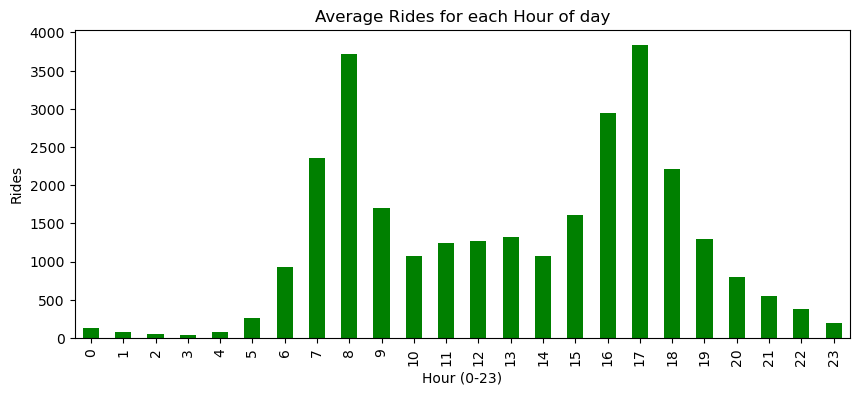

In [24]:
hourly_average = df.groupby('HOUR').size()

plt.figure(figsize=(10, 4))
hourly_average.plot(kind='bar', color='green')
plt.title('Average Rides for each Hour of day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Rides')

**Insights**: 
I noticed that the average of rides spikes up at 8AM, only to spike up once again at 5PM; This seems to be a reasonable conclusion to make due to a 9-5 being a typical time frame for a career, however the bar plot shows that 9AM has about only half of the rides 8AM has. Perhaps 9 hour shifts are common in this area?

# Step 4: Feature engineering

In [25]:
def add_features(df):

    # Counting rides per hour.
    hourly_rides = df.resample('H', on='START TIME').size().reset_index(name='RIDES')
    
    df = df.copy()
    
    # Time feature, although this code is a repeat because I showed it earlier; I just thought it'd fit in here.
    hourly_rides['HOUR'] = df['START TIME'].dt.hour
    
    # Rush hour feature; Numbers are based on observations on the bar plot.
    hourly_rides['IS_RUSH_HOUR'] = df['HOUR'].isin([7, 8, 16, 17]).astype(int)
    
    # Replacing missing values.
    df.fillna(0, inplace=True)
    
    # Lag features.
    hourly_rides['RIDE LAGS 1'] = hourly_rides['RIDES'].shift(1) # Uses rides from last hour to predict next hour.
    hourly_rides['RIDE LAGS 24'] = hourly_rides['RIDES'].shift(24) # Uses rides from the same hour yesterday to predict today.
    
    # Rolling averages - Averaging rides over the last 3 hours.
    hourly_rides['ROLLING AVGS'] = hourly_rides['RIDES'].rolling(3, min_periods=1).mean()
    
    return hourly_rides

hourly_rides = add_features(df)

# Drop rows with NaNs caused by lag/rolling features
hourly_rides = hourly_rides.dropna()

# Define features X and target y for RandomForest model
feature_columns = ['HOUR', 'IS_RUSH_HOUR', 'RIDE LAGS 1', 'RIDE LAGS 24', 'ROLLING AVGS']
X = hourly_rides[feature_columns]
y = hourly_rides['RIDES']

# Step 5: Train/Test split

In [26]:
# Chronological order
hourly_rides = hourly_rides.sort_values('START TIME')

# Train/Test
split_time = hourly_rides['START TIME'].iloc[-48] # Last 48 hours for testing
train = hourly_rides[hourly_rides['START TIME'] < split_time] # Trains all rows before split time.
test = hourly_rides[hourly_rides['START TIME'] >= split_time] # Tests all rows after split time.

# Step 6A – Model Selection (Prophet)
I'm going to start with **Prophet**, which works best for time patterns, and after that, **RandomForest** for my engineered features.

In [27]:
# Converting training data.
prophet_train = train.reset_index()[['START TIME', 'RIDES']].rename(columns={'START TIME': 'ds', 'RIDES': 'y'})

# Adding engineered features as regressors.
prophet_train['IS_RUSH_HOUR'] = train['IS_RUSH_HOUR'].values
prophet_train['HOUR'] = train['HOUR'].values

**Initializing and fitting the model**:

In [28]:
!pip install prophet
from prophet import Prophet

# Replace NaNs with 0
prophet_train['HOUR'] = prophet_train['HOUR'].fillna(0)  

# Also check the IS_RUSH_HOUR column for NaNs
if 'IS_RUSH_HOUR' in prophet_train.columns:
    prophet_train['IS_RUSH_HOUR'] = prophet_train['IS_RUSH_HOUR'].fillna(0)

model = Prophet(
    daily_seasonality=True,  # To capture hourly patterns
    weekly_seasonality=False,  # Disabling weekly as I only have 6 days
    yearly_seasonality=False,  # Disabling yearly for the same reason
    changepoint_prior_scale=0.1  # Reducing flexibility for small datasets
)

# Adding my regressors 
model.add_regressor('HOUR')
model.add_regressor('IS_RUSH_HOUR')

# Fitting the model
model.fit(prophet_train)

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


08:32:56 - cmdstanpy - INFO - Chain [1] start processing
08:32:56 - cmdstanpy - INFO - Chain [1] done processing


**Creating future dataframe**:

In [29]:
# Generating future timestamps.
future = test.reset_index()[['START TIME']].rename(columns={'START TIME': 'ds'})

# Adding regressors to future data.
future['IS_RUSH_HOUR'] = test['IS_RUSH_HOUR'].values
future['HOUR'] = test['HOUR'].values

# Making predictions with Prophet.
forecast = model.predict(future)
forecasted_values_prophet = forecast['yhat'].values

Text(0.5, 1.0, 'Prophet Predictions vs Actual')

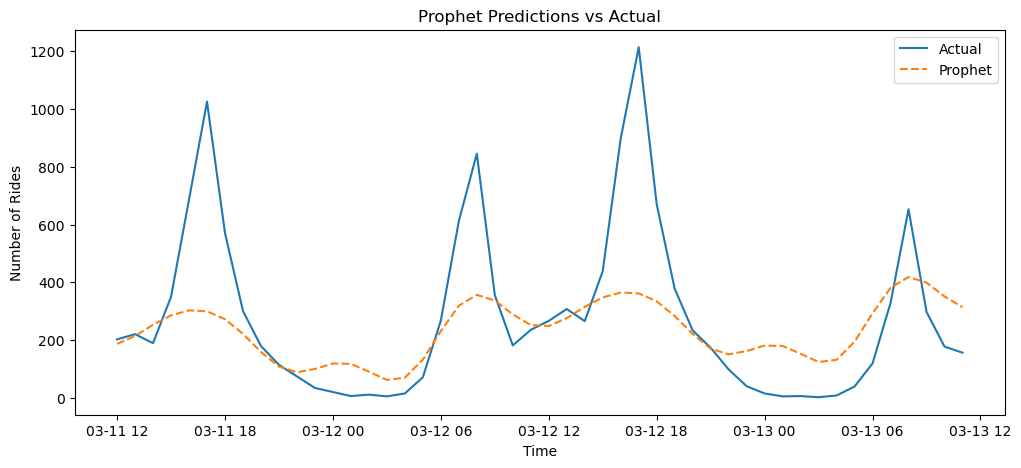

In [30]:
# Prophet predictions vs actual 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(test['START TIME'], test['RIDES'], label='Actual') # Plotting the true bike demand
plt.plot(test['START TIME'], forecasted_values_prophet, label='Prophet', linestyle='--') # Plotting prophet's predicted values
plt.xlabel('Time')
plt.ylabel('Number of Rides')
plt.legend()
plt.title("Prophet Predictions vs Actual") 

**Prophet Residual Errors**:

In [31]:
# Residuals = actual - predicted
prophet_residuals = test['RIDES'] - forecasted_values_prophet
prophet_residuals.mean()

44.60691940051609

The mean of the residuals is positive, meaning that Prophet **underpredicts** on average. We can see this on the graph too.

# Step 6B – Model Selection (RandomForest)¶
**Train/Test split pt.2**

In [32]:
split_time = hourly_rides['START TIME'].iloc[-48] # Last 48 hours for testing

train = hourly_rides[hourly_rides['START TIME'] < split_time] # Trains all rows before split time.
test = hourly_rides[hourly_rides['START TIME'] >= split_time] # Trains all rows after split time.

X_train = train[feature_columns] # Training features: input variables for the model
y_train = train['RIDES'] # Training target: what we want the model to predict
X_test = test[feature_columns] # Testing features: input variables the model hasn't seen
y_test = test['RIDES'] # Testing target: actual values to compare predictions against

**Initializing and fitting the model**:

In [33]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
randomforest = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
randomforest.fit(X_train, y_train)

forecasted_values_rf = randomforest.predict(X_test)

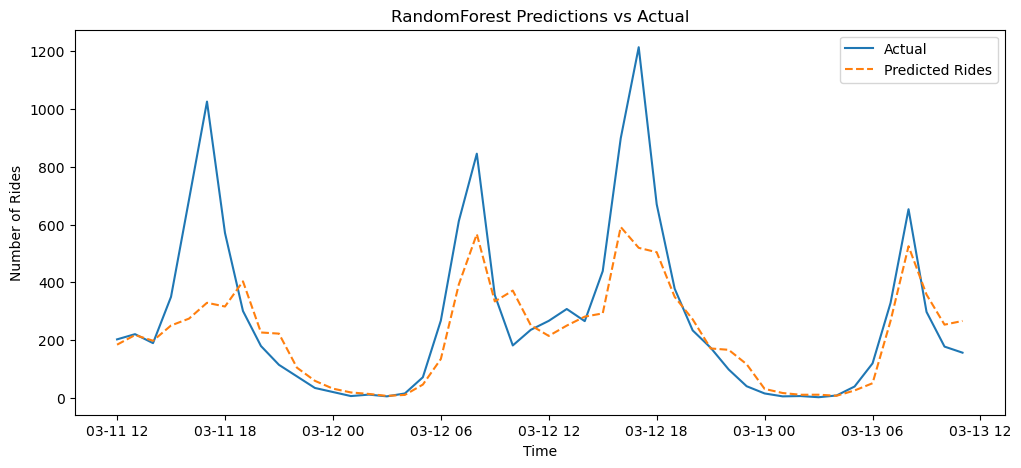

In [34]:
# RandomFores predictions vs actual 
plt.figure(figsize=(12, 5))
plt.plot(test['START TIME'], y_test, label='Actual') # Plotting the true bike demand
plt.plot(test['START TIME'], forecasted_values_rf, label='Predicted Rides', linestyle='--') # Plotting Random Forest's predicted values
plt.xlabel('Time')
plt.ylabel('Number of Rides')
plt.legend()
plt.title("RandomForest Predictions vs Actual") 
plt.show()

**RandomForest Residual Errors**:

In [35]:
rf_residuals = y_test - forecasted_values_rf
rf_residuals.mean()

59.40083333333334

The mean of the residuals is positive, meaning that Prophet **underpredicts** on average. However, both visually and by the numerical result, it isn't as inaccurate as Prophet's residual mean.

# Step 8 – Project conclusion

**Evaluating performances of both models, starting with Prophet:**

In [36]:
PROPHET_RMSE = mean_squared_error(test['RIDES'], forecasted_values_prophet, squared=False)
PROPHET_MAE = mean_absolute_error(test['RIDES'], forecasted_values_prophet)

print(f"RMSE: {PROPHET_RMSE:.1f}")
print(f"MAE: {PROPHET_MAE:.1f}")

RMSE: 232.8
MAE: 148.6


MAE: On average, my predictions were 148.6 rides off from the actual hourly demand.

RMSE: On average, my errors were about 232.8 rides, with larger mistakes weighted more heavily.

**Key Insight**: Because RMSE > MAE, the gap between MAE and RMSE suggests I have some hours with very large prediction errors.

**RandomForest**:

In [37]:
forecasted_values_rf = randomforest.predict(X_test)

RF_RMSE = mean_squared_error(y_test, forecasted_values_rf, squared=False)
RF_MAE = mean_absolute_error(y_test, forecasted_values_rf)

print(f"RMSE: {RF_RMSE:.1f}") # 1f means one decimal place.
print(f"MAE: {RF_MAE:.1f}")

RMSE: 183.9
MAE: 102.6


MAE: On average, my predictions were 102.6 rides off from the actual hourly demand.

RMSE: On average, my errors were about 183.9 rides, with larger mistakes weighted more heavily.

**Key Insight**: Because RMSE > MAE, the gap between MAE and RMSE suggests I have some hours with somewhat large prediction errors, though the error is not as large as it is with the Prophet model.

Evidently, the more accurate model ended up being RandomForest. As previously stated, the difference in MAE and RMSE was smaller with RandomForest. The visualizations also proved RandomForest's predictions of bicycle demand to more closely resemble the trends of the original dataset as well.

# Summary:

The goal of this project was to predict the hourly bicycle demand in the city of Chicago by using and comparing two models. I used a dataset from Chicago's official website that contained hourly bike rental data. Based on the mean absolute errors between both models, with Prophet being 148.6, and RandomForest being 102.6, RandomForest outperformed Prophet by:

In [38]:
improvement_percentage = ((PROPHET_MAE - RF_MAE) / PROPHET_MAE) * 100
improvement_percentage

30.94093181061665

About 31%. This difference in result may be because of the fact that RandomForest works with engineered features, emphasizing the importance of using them in terms of prediction-related projects. Also, Prophet is known to rely on seasonality, so I was only able to apply seasonality for days; It was a big limitation for Prophet in that I couldn't work with weeks or months. For smaller datasets like this, it seems that using engineered features and working with RandomForest is a better choice overall for more accurate predictions. Visual analysis from earlier also further confirmed RandomForest's superiority.

Throughout this experience, I gained hands-on-experience with learning how how to clean data, feature engineer, train/test split and utilize machine learning algorithms (Prophet and RandomForest) in order to make predictions and to find out which worked better for this specific project. As a result, I am proud to say that I have solidified my foundational understanding of the essence of applied machine learning.